In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

In [3]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # Windows: 黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 防止负号显示异常

In [4]:
g2 = 50.0    # 耦合常数（单位任意）
mu = 0.5     # 屏蔽参数

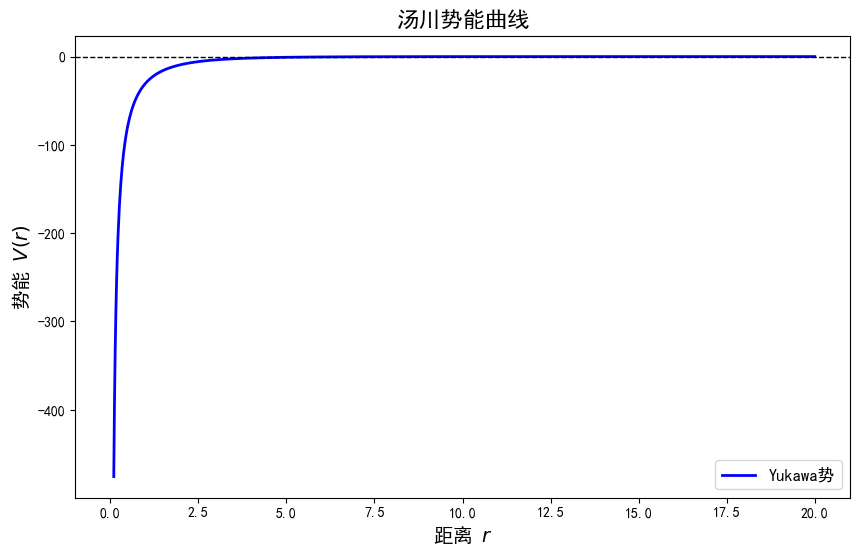

In [15]:
# 定义Yukawa势能函数
def yukawa_potential(r, g2=g2, mu=mu):
    return -g2 * np.exp(-mu * r) / r

# 构造距离数组，避免 r=0
r_values = np.linspace(0.1, 20, 1000)
V_values = yukawa_potential(r_values)

# 绘制势能曲线
plt.figure(figsize=(10, 6))
plt.plot(r_values, V_values, 'b-', lw=2, label="Yukawa势")
plt.xlabel("距离 $r$", fontsize=14)
plt.ylabel("势能 $V(r)$", fontsize=14)
plt.title("汤川势能曲线", fontsize=16)
plt.legend(fontsize=12)
plt.axline((0, 0), (20, 0), color='black', lw=1,linestyle='--', label="x轴")
plt.savefig("./output/Yukawa_potenial.png")
plt.show()


In [6]:
# 定义 Yukawa 势下的加速度函数
def yukawa_acceleration(r, g2=g2, mu=mu):
    x, y = r
    r_norm = np.sqrt(x*x + y*y)
    # 为避免 r=0 处奇异，作简单处理
    if r_norm < 1e-6:
        return np.array([0.0, 0.0])
    factor = -g2 * np.exp(-mu * r_norm) * (mu/r_norm + 1/(r_norm**2)) / (r_norm)
    return factor * np.array([x, y])

In [7]:
dt = 0.01          # 时间步长
steps = 2000       # 最大时间步数
v0 = 20.0          # 初始水平速度（固定）
X0 = -30.0         # 发射点 x 坐标

In [8]:
impact_parameters = np.linspace(-3, 3, 10)

In [9]:
trajectories = []

for b in impact_parameters:
    # 初始位置：(-30, b)
    r = np.array([X0, b])
    # 初始速度：水平方向，大小 v0；竖直分量为 0
    v = np.array([v0, 0.0])
    traj = [r.copy()]
    
    # 采用速度-Verlet方法模拟运动
    for i in range(steps):
        # 当前加速度
        a = yukawa_acceleration(r)
        # 位置更新： r_new = r + v*dt + 0.5*a*dt^2
        r_new = r + v * dt + 0.5 * a * dt**2
        # 计算新的加速度
        a_new = yukawa_acceleration(r_new)
        # 速度更新： v_new = v + 0.5*(a + a_new)*dt
        v = v + 0.5 * (a + a_new) * dt
        # 更新位置
        r = r_new
        traj.append(r.copy())
        # 如果粒子已经远离散射区（例如 x > 50），可退出模拟
        if r[0] > 50:
            break
    trajectories.append(np.array(traj))

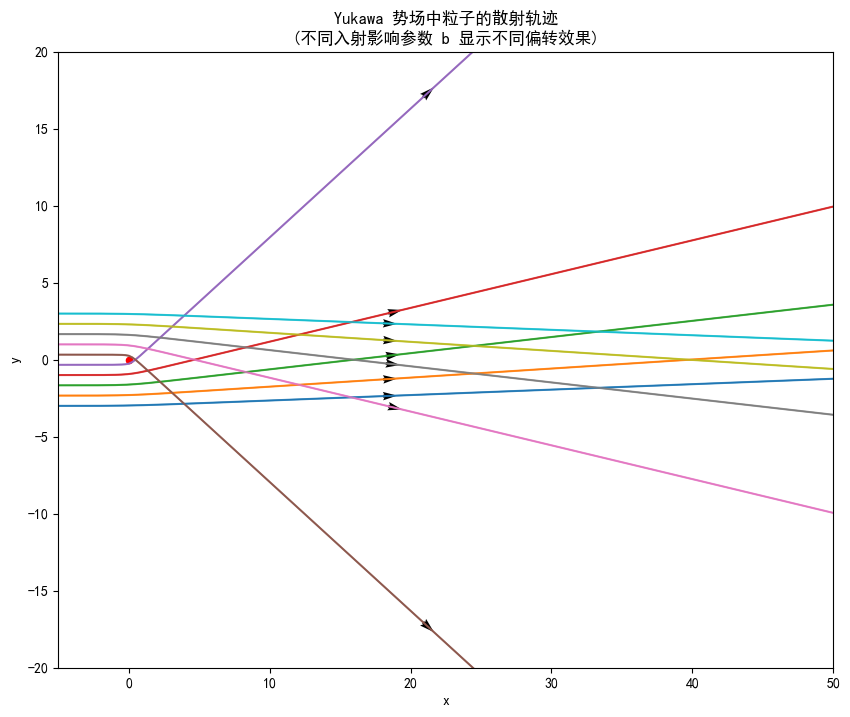

In [10]:
plt.figure(figsize=(10, 8))
for traj in trajectories:
    plt.plot(traj[:, 0], traj[:, 1], lw=1)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Yukawa 势场中粒子的散射轨迹\n(不同入射影响参数 b 显示不同偏转效果)")
# 另一个核子的位置
X_nuc = 0
Y_nuc = 0
for traj in trajectories:
    plt.plot(traj[:, 0], traj[:, 1], lw=1.5, alpha=0.8)
    
    arrow_index = int(len(traj) * 0.6)
    if arrow_index < len(traj) - 1:
        start_point = traj[arrow_index]
        end_point = traj[arrow_index + 1]
        vector = end_point - start_point
        # 若需要调整箭头大小，可加放大系数
        scale_factor = 5  # 根据效果调整
        vector = vector * scale_factor
        plt.quiver(start_point[0], start_point[1], vector[0], vector[1],
                  angles='xy', scale_units='xy', scale=1, color='black')


# 在图中标记出核子的位置
plt.ylim([-20, 20])
plt.xlim([-5, 50])
plt.scatter(X_nuc, Y_nuc, color='red', s=20, label='目标核子')
plt.savefig("./output/Yukawa.png")
plt.show()

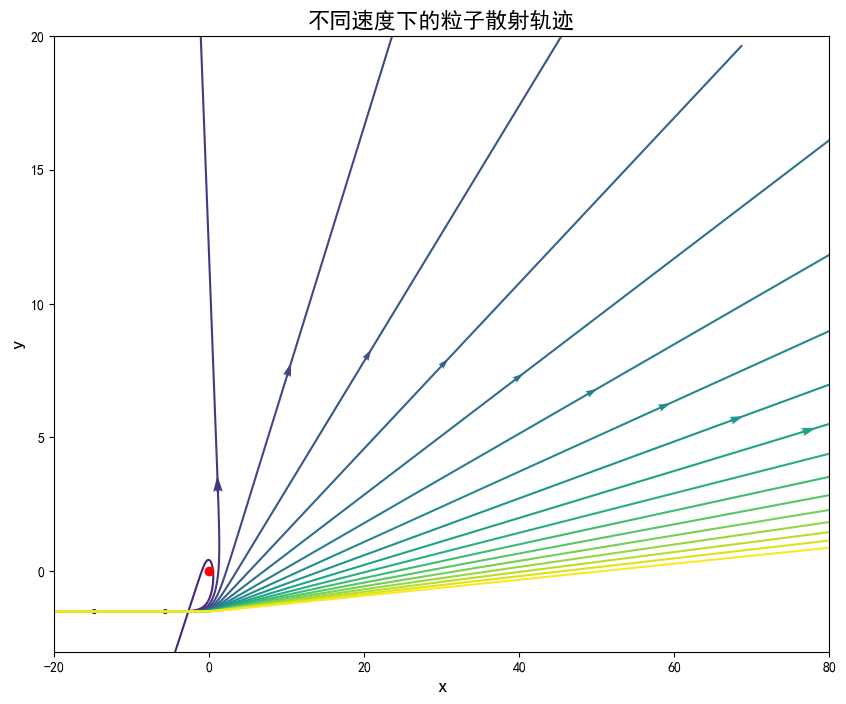

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# 基本参数
steps = 1000
dt = 0.01
b_values = [-1.5]  # 瞄准距离
speed_values = np.linspace(1, 30, 20)  # 5个不同初始速度

# Yukawa 势参数
g2 = 50
mu = 0.5

# Yukawa 势函数
def yukawa_force(r_vec):
    r = np.linalg.norm(r_vec)
    if r == 0:
        return np.array([0.0, 0.0])
    factor = g2 * (mu + 1/r) * np.exp(-mu * r) / r**2
    return -factor * r_vec / r

# 存储颜色和线型
colors = plt.cm.viridis(np.linspace(0, 1, len(speed_values)))

# 图像设置
plt.figure(figsize=(10, 8))
for si, speed in enumerate(speed_values):
    for b in b_values:
        # 初始位置和速度
        r = np.array([-30.0, b])
        v = np.array([speed, 0.0])

        trajectory = np.zeros((steps, 2))
        for i in range(steps):
            trajectory[i] = r
            a = yukawa_force(r)
            r = r + v * dt + 0.5 * a * dt**2
            v = v + a * dt

        plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[si],
                 label=f"v0 = {speed}" if b == b_values[0] else "", linewidth=1.5)
        # 添加箭头：选择轨迹中 40% 位置作为箭头起点
        arrow_index = int(steps * 0.6)
        if arrow_index < steps - 1:
            start_point = trajectory[arrow_index]
            end_point = trajectory[arrow_index + 1]
            vector = end_point - start_point
            # 可根据需要调整箭头长度，这里乘以放大系数
            scale_factor = 10
            vector = vector * scale_factor
            plt.quiver(start_point[0], start_point[1],
                       vector[0], vector[1],
                       angles='xy', scale_units='xy', scale=1,
                       color=colors[si])

# 绘制核子位置
plt.plot(0, 0, 'ro', markersize=6, label="核子")

plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("不同速度下的粒子散射轨迹", fontsize=16)
plt.xlim(-20,80)
plt.ylim(-3,20)
plt.savefig("./output/Yukawa_speed.png")
plt.show()


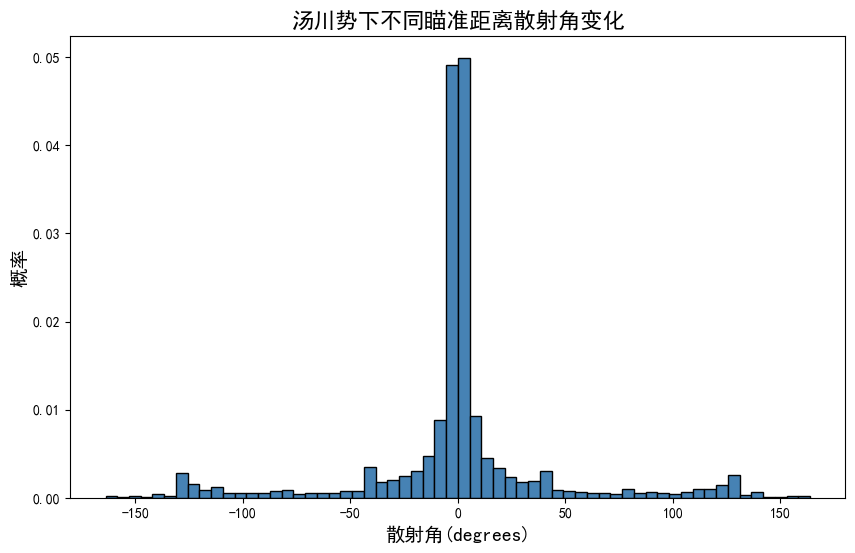

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# 模拟参数
num_particles = 20000
steps = 2000
dt = 0.01
speed = 10.0
b_min, b_max = -5.0, 5.0  # 瞄准距离范围
x0 = -30.0                # 入射起始位置

# Yukawa 势参数
g2 = 50
mu = 0.5

# Yukawa 势导出的力函数
def yukawa_force(r_vec):
    r = np.linalg.norm(r_vec)
    if r == 0:
        return np.array([0.0, 0.0])
    factor = g2 * (mu + 1/r) * np.exp(-mu * r) / r**2
    return -factor * r_vec / r


# 检查缓存
if not os.path.exists("./output/Yukawa_MontCal_angle.npy"):
    # 用于保存所有散射角（单位：弧度）
    scattering_angles = []
    
    for _ in range(num_particles):
        b = np.random.uniform(b_min, b_max)
        r = np.array([x0, b])
        v = np.array([speed, 0.0])
    
        for i in range(steps):
            a = yukawa_force(r)
            r = r + v * dt + 0.5 * a * dt**2
            v = v + a * dt
    
            # 粒子已经足够远离核子，可认为散射过程结束
            if np.linalg.norm(r) > 40:
                angle = np.arctan2(v[1], v[0])  # 最终速度方向与 x 轴的夹角
                scattering_angles.append(np.degrees(angle))  # 转为角度
                break
else:
    # 从缓存中读取散射角数据
    scattering_angles = np.load("./output/Yukawa_MontCal_angle.npy")


# 绘制直方图（散射角分布）
plt.figure(figsize=(10, 6))
plt.hist(scattering_angles, bins=60, density=True, color='steelblue', edgecolor='black')
plt.xlabel("散射角(degrees)", fontsize=14)
plt.ylabel("概率", fontsize=14)
plt.title("汤川势下不同瞄准距离散射角变化", fontsize=16)
plt.savefig("./output/Yukawa_MontCal_angle.png")
plt.show()


In [60]:
# 缓存结果数组
np.save("./output/Yukawa_MontCal_angle.npy", np.array(scattering_angles))

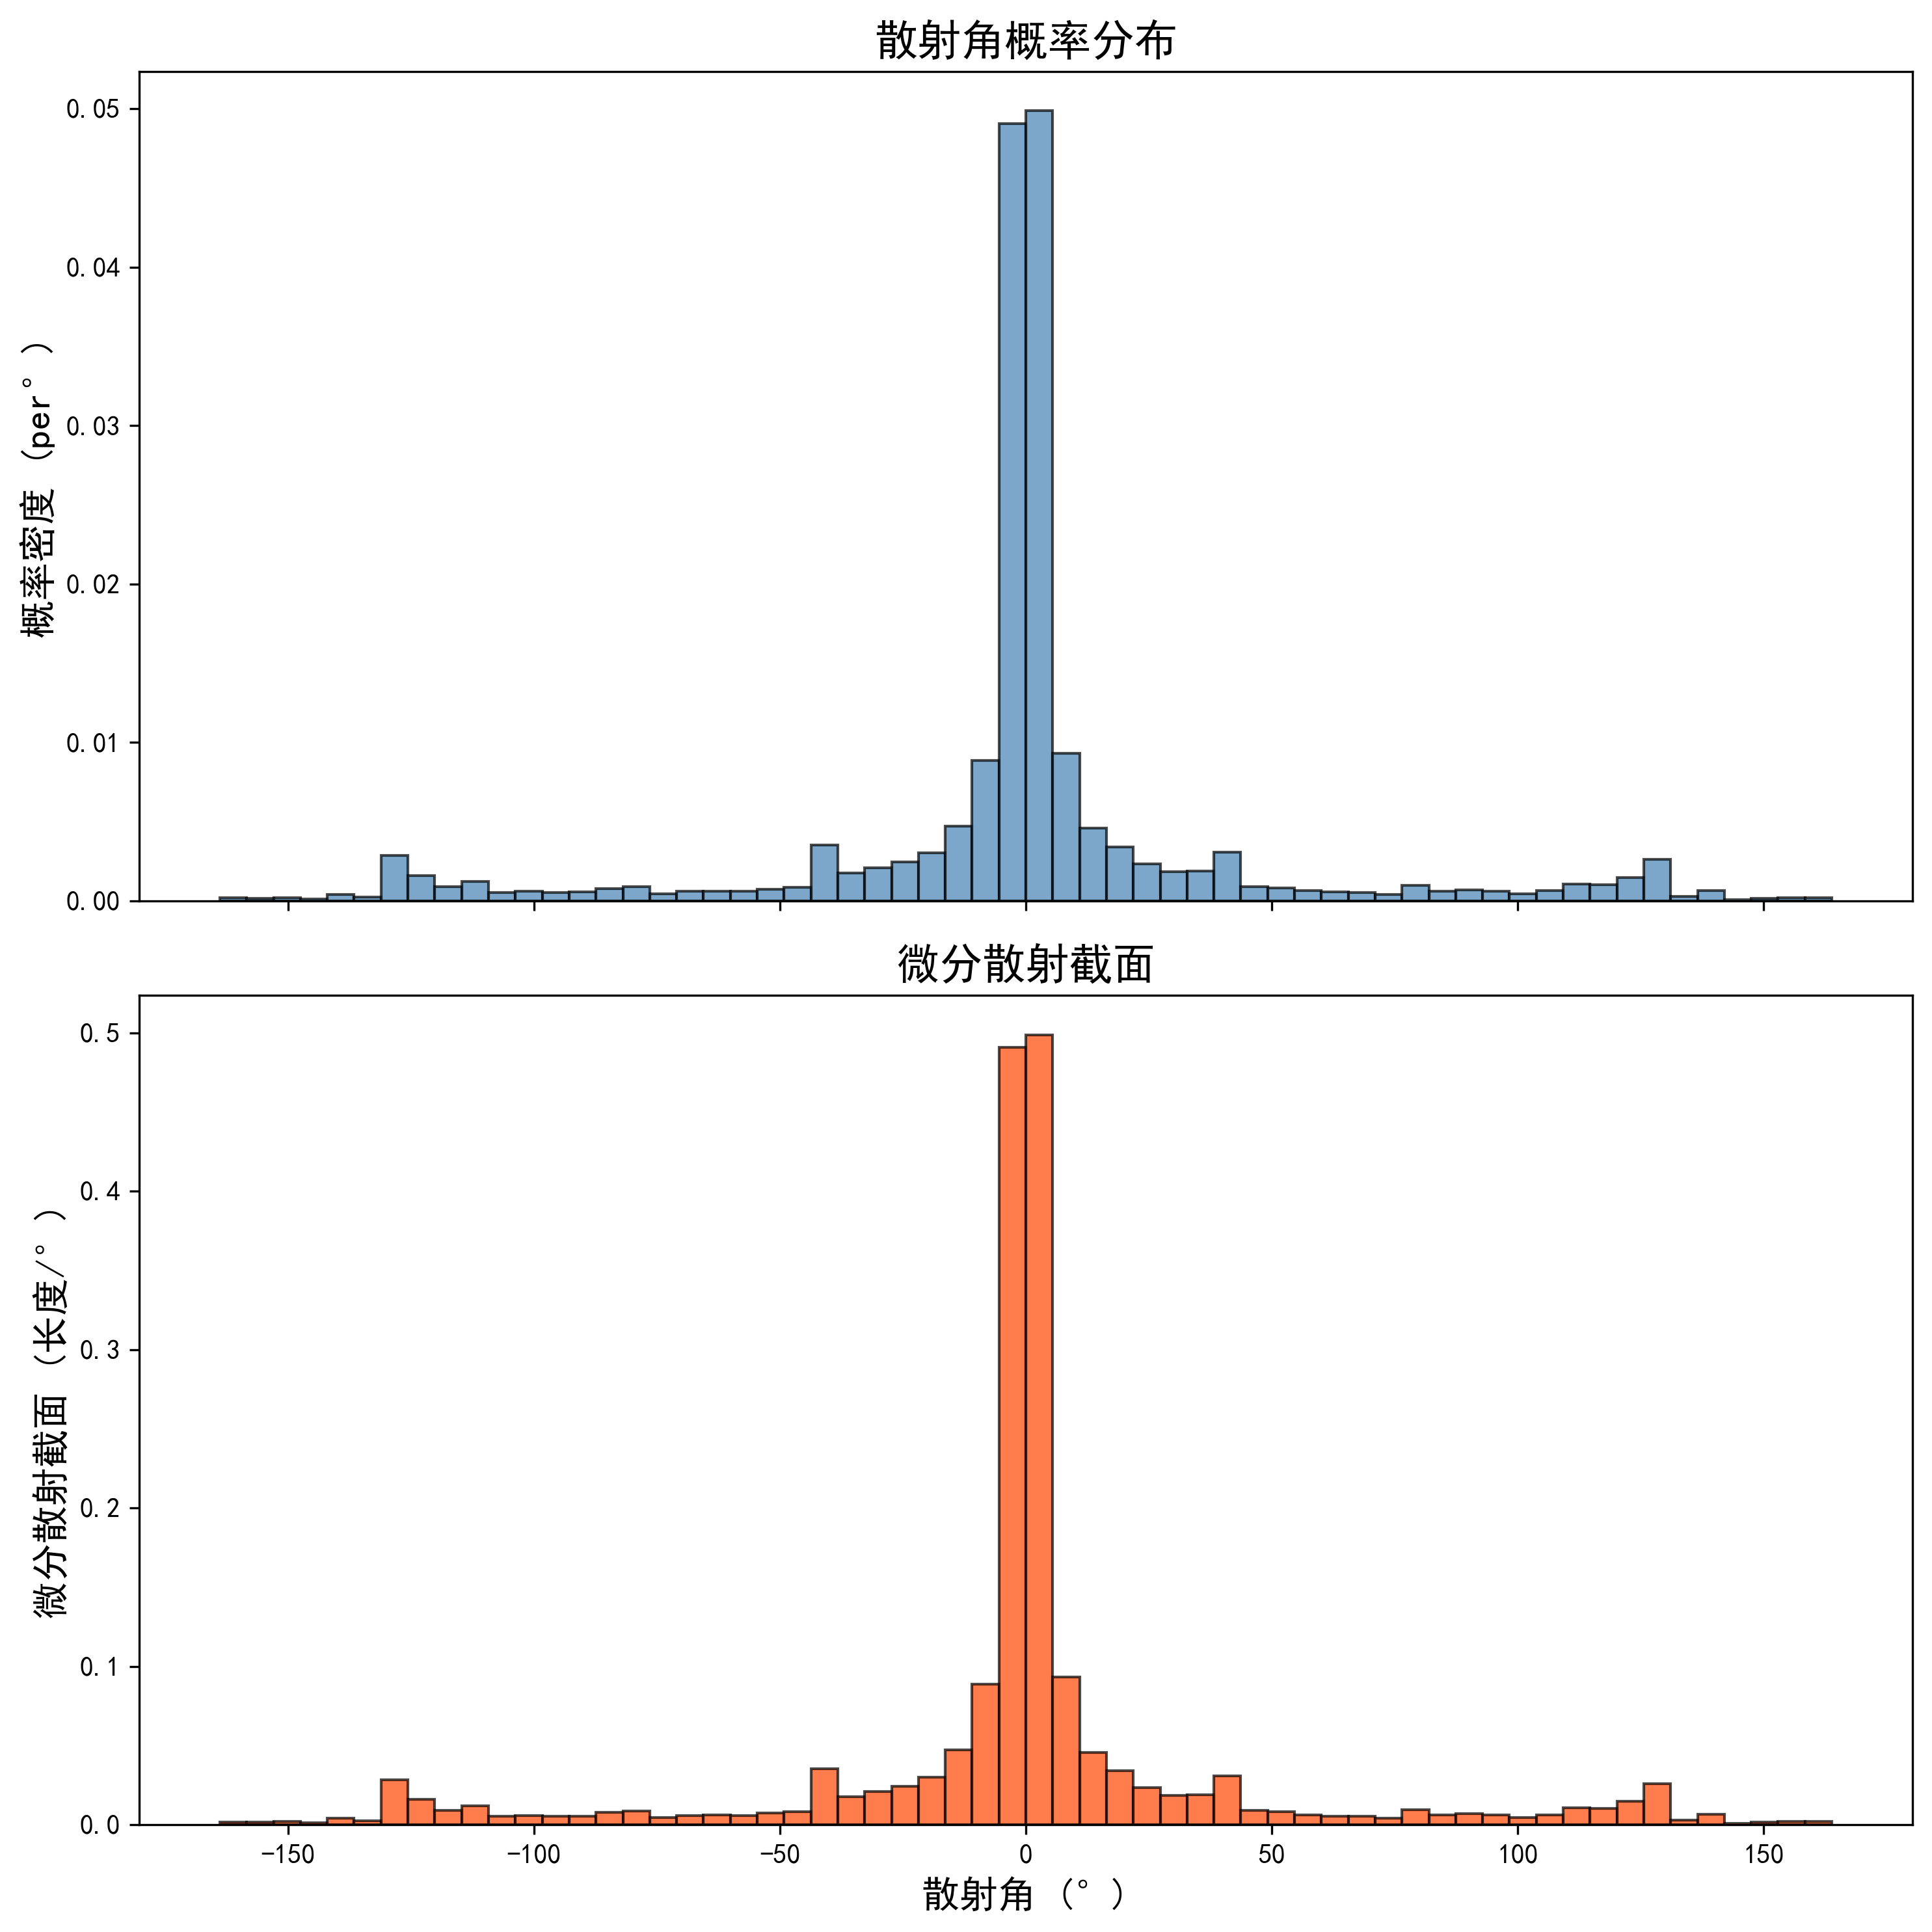

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


num_particles = 20000
steps = 2000
dt = 0.01
speed = 10.0
b_min, b_max = -5.0, 5.0  # 瞄准距离范围，单位为长度（例如，cm或m等）
x0 = -30.0               # 入射起始位置

# Yukawa 势参数
g2 = 50
mu = 0.5

# Yukawa 势导出的力函数（二维）
def yukawa_force(r_vec):
    r = np.linalg.norm(r_vec)
    if r == 0:
        return np.array([0.0, 0.0])
    factor = g2 * (mu + 1/r) * np.exp(-mu * r) / r**2
    # 注意这里的负号决定了力的方向
    return -factor * r_vec / r

cache_file = "./output/Yukawa_MontCal_angle.npy"
if not os.path.exists(cache_file):
    scattering_angles = []  # 记录散射角（单位：弧度）
    
    for _ in tqdm(range(num_particles), desc="Simulating particles"):
        b = np.random.uniform(b_min, b_max)
        r = np.array([x0, b])
        v = np.array([speed, 0.0])
    
        for i in range(steps):
            a = yukawa_force(r)
            r = r + v * dt + 0.5 * a * dt**2
            v = v + a * dt
    
            # 当粒子足够远离散射中心（例如 x > 40），认为散射过程结束
            if np.linalg.norm(r) > 40:
                theta = np.arctan2(v[1], v[0])  # 散射角（弧度），假设 v[0] > 0
                scattering_angles.append(theta)
                break
    
    scattering_angles = np.array(scattering_angles)
    # 转换为角度（单位：度）
    scattering_angles_deg = np.degrees(scattering_angles)
    np.save(cache_file, scattering_angles_deg)
else:
    scattering_angles_deg = np.load(cache_file)

num_bins = 60
hist_vals, bin_edges = np.histogram(scattering_angles_deg, bins=num_bins, density=True)
# hist_vals 的单位: per degree (如果直方图的积分为1)
# 计算直方图中心值
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

# 总入射截面（二维）= b_max - b_min
sigma_total = b_max - b_min  # 单位：长度


diff_sigma = sigma_total * hist_vals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=300, sharex=True)


ax1.bar(bin_centers, hist_vals, width=(bin_edges[1]-bin_edges[0]), 
        color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_ylabel("概率密度 (per°)", fontsize=14)
ax1.set_title("散射角概率分布", fontsize=16)



ax2.bar(bin_centers, diff_sigma, width=(bin_edges[1]-bin_edges[0]), 
        color='orangered', edgecolor='black', alpha=0.7)
ax2.set_xlabel("散射角 (°)", fontsize=14)
ax2.set_ylabel("微分散射截面 (长度/°)", fontsize=14)
ax2.set_title("微分散射截面", fontsize=16)


plt.tight_layout()
plt.savefig("./output/Yukawa_MontCal_angle_hist_with_jiemian.png")
plt.show()
